<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/image_similarity_with_siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Siamese Network Demonstration

**Author**: W. Tod Newman

**Updates**:  First revision
## Learning Objectives


*  Learn how a Siamese network can be created
*  See visualization of image similarity


## Overview
With the kernel I am trying to run a simple test on using Siamese networks for similarity on a slightly more complicated problem than standard MNIST.  The idea is to take a randomly initialized network and apply it to images to find out how similar they are. The models should make it much easier to perform tasks like Visual Search on a database of images since it will have a simple similarity metric between 0 and 1 instead of 2D arrays.

In [ ]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt


# Load and Organize Data
Here we load and organize the data so we can easily use it inside of Keras models

In [ ]:
import keras
from sklearn.model_selection import train_test_split

from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#!gunzip 'input/data/train-images-idx3-ubyte.gz'
#%ls input/data

#data_train = pd.read_csv('input/data/train-images-idx3-ubyte')
#X_full = data_train.iloc[:,1:]
#y_full = data_train.iloc[:,:1]
#x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [ ]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


### Batch Generation
Here the idea is to make usuable batches for training the network. We need to create parallel inputs for the $A$ and $B$ images where the output is the distance. Here we make the naive assumption that if images are in the same group the similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

In [ ]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

## Validate Data
Here we make sure the generator is doing something sensible, we show the images and their similarity percentage.  Again, this is somewhat bogus still... we're assuming that if the images are in the same group, similarity a equals 1 and if they're in different groups, similarity equals zero.

This will change once we start evaluating the images for similarity.

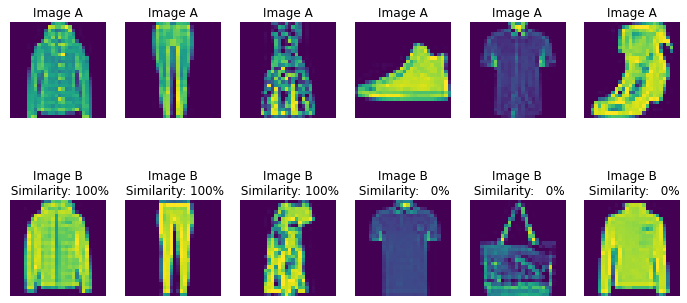

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

# Feature Generation
Here we make the feature generation network to process images into features. The network starts off randomly initialized and will be trained to generate useful vector features from input images (_hopefully_)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout


# Define Input Layer Up front.
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

# Create our convolutional network in a compressing fashion... 
# 4 Conv Layers with 8, 16, 16, and 32 filters respectively.

for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

# Siamese Model
We apply the feature generating model to both images and then combine them together to predict if they are similar or not. The model is designed to be very simple. The ultimate idea is when a new image is taken that a feature vector can be calculated for it using the _FeatureGenerationModel_. All existing images have been pre-calculated and stored in a database of feature vectors. The model can be applied using a few vector additions and multiplications to determine the most similar images. These operations can be implemented as a stored procedure or similar task inside the database itself since they do not require an entire deep learning framework to run.

In [ ]:
from keras.layers import concatenate

# Our Similarity Model will Have Dual Inputs, one for each image
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

# Run each Input layer through the feature model
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)

# Concatenate results into a similarity model
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [ ]:
# Compile our similarity model to setup the optimization process
similarity_model.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics = ['mae'])

## Visual Model Feedback
Here we visualize what the model does by taking a small sample of randomly selected A and B images the first half from the same category and the second from different categories. We then show the actual distance (0 for the same category and 1 for different categories) as well as the model predicted distance. The first run here is with a completely untrained network so we do not expect meaningful results.

Note that most of the predictions are similar to a coin flip.  This is what we'd expect before we train the model.

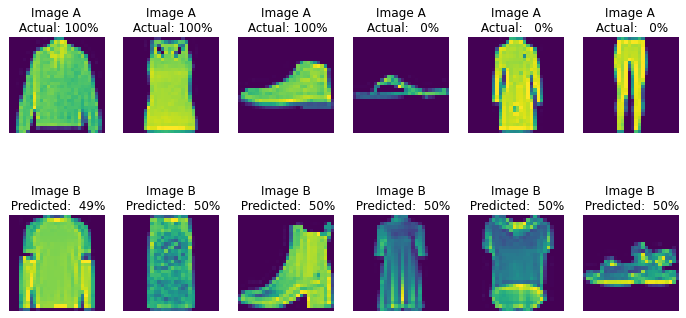

In [ ]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    
    # Predict using the untrained model.
    
    pred_sim = similarity_model.predict([pv_a, pv_b])
    
    # Plot results
    
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

_ = show_model_output()

In [ ]:
# make a generator out of the data.  Yield images A and B and score.
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
        
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)

# Fit the model using Keras' fit_generator.
loss_history = similarity_model.fit(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 30,
                                             verbose = True)

Epoch 1/30
500/500 [==============================] - 83s 142ms/step - loss: 0.6374 - mae: 0.4525 - val_loss: 0.5114 - val_mae: 0.3686
Epoch 2/30
500/500 [==============================] - 63s 126ms/step - loss: 0.5072 - mae: 0.3594 - val_loss: 0.4303 - val_mae: 0.2937
Epoch 3/30
500/500 [==============================] - 62s 125ms/step - loss: 0.4612 - mae: 0.3163 - val_loss: 0.3947 - val_mae: 0.2593
Epoch 4/30
500/500 [==============================] - 61s 123ms/step - loss: 0.4350 - mae: 0.2931 - val_loss: 0.3708 - val_mae: 0.2452
Epoch 5/30
500/500 [==============================] - 63s 126ms/step - loss: 0.4150 - mae: 0.2776 - val_loss: 0.3595 - val_mae: 0.2396
Epoch 6/30
500/500 [==============================] - 64s 128ms/step - loss: 0.3951 - mae: 0.2610 - val_loss: 0.3390 - val_mae: 0.2213
Epoch 7/30
500/500 [==============================] - 64s 128ms/step - loss: 0.3851 - mae: 0.2511 - val_loss: 0.3319 - val_mae: 0.2146
Epoch 8/30
500/500 [==============================] - 6

## After Training

Note that now we're predicting much better.  In the cases where the actual similarity between the two objects is zero, we're now predicting lower similarity probabilities.  In cases where the items are the same, we're predicting a much higher probability of similarity now. 

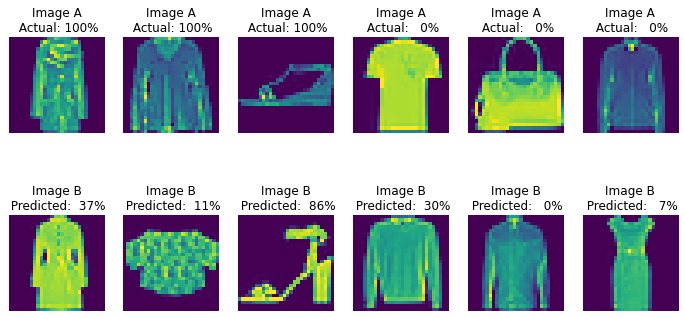

In [ ]:
_ = show_model_output()

# T-Shirt vs Ankle Boot-Plot
Here we take random t-shirt and ankle boot (categories 0 and 9) images and calculate the distance using our network to the other images

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

79/79 [==============================] - 6s 74ms/step


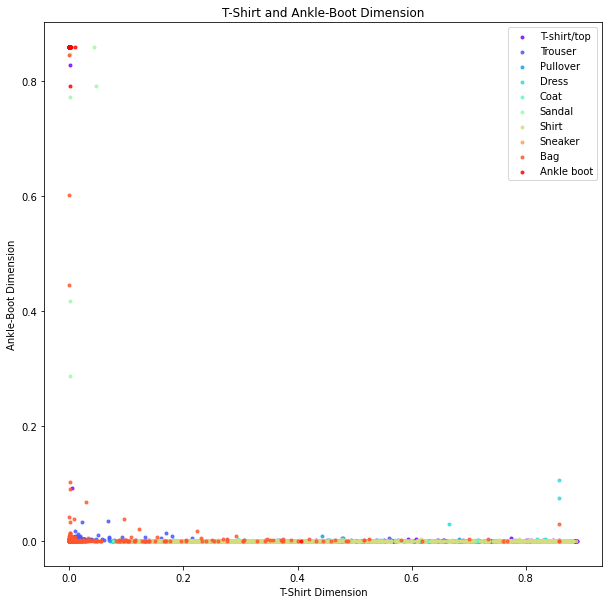

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

## Examining the Features
Here we aim to answer the more general question: did we generate useful features with the Feature Generation model? And how can we visualize this.

In [ ]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 3s 42ms/step


## Neighbor Visualization
For this we use the T-SNE neighborhood embedding to visualize the features on a 2D plane and see if it roughly corresponds to the groups. We use the test data for this example as well since the training has been contaminated

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.672s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.137212
[t-SNE] Computed conditional probabilities in 0.576s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 76.9723206, gradient norm = 0.0027008 (50 iterations in 4.565s)
[t-SNE] Iteration 100: error = 75.7770691, gradient norm = 0.0014287 (50 iterations in 4.465s)
[t-SNE] Iteration 150: error = 75.2357254, gradient norm = 0.0010106 (50 iterations in 4.313s)
[t-SNE] Iteration 200: error = 74.9212341, gradient norm = 0.0008049 (50 iterations in 4.519s)
[t-SNE] Iteration 250: error = 74.7178421, gradient norm = 0.0006654 (50 iterations in 4.297s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.717842
[t-SNE] Iteration 300: error = 2.6463361, gradient norm = 0.0012912 (50 iterations in 4.411s)
[t-SNE] Iteration 350: error = 2.1561351, gradient norm = 0.0005772 (50 iterations in 4.771s)
[t-SNE] Iteration 400: error = 1.9165635, gradient norm = 0.0003446 (50 iterations in 4.557s)
[t-SNE] Iteration 450: error = 1.7759145, gradient norm = 0.0002356 (50 iterations in 4.827s)
[t-SNE] Iteration 500: error = 1.6832187, gradient norm = 0.0001736 (50 

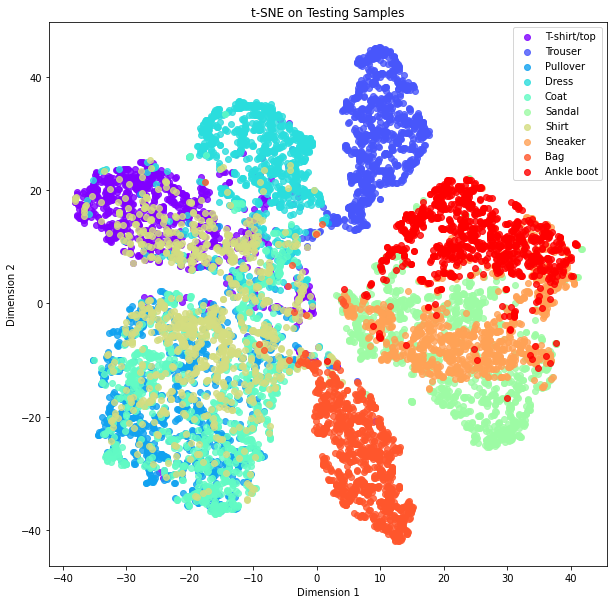

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [ ]:
feature_model.save('fashion_feature_model.h5')

In [ ]:
similarity_model.save('fashion_similarity_model.h5')

#  Pull in test dataset for transfer learning